<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Regression-CNN" data-toc-modified-id="Regression-CNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regression CNN</a></span><ul class="toc-item"><li><span><a href="#Define-Model-Architecture" data-toc-modified-id="Define-Model-Architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define Model Architecture</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Test-CNN-with-Generated-Images" data-toc-modified-id="Test-CNN-with-Generated-Images-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Test CNN with Generated Images</a></span></li></ul></li><li><span><a href="#SSIM-cGAN-(Mode-Collapse)" data-toc-modified-id="SSIM-cGAN-(Mode-Collapse)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SSIM cGAN (Mode Collapse)</a></span></li><li><span><a href="#FID" data-toc-modified-id="FID-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>FID</a></span></li></ul></div>

# Setup

In [ ]:
import logging
import os
import random

import numpy as np
from numpy import load, cov, trace, iscomplexobj, asarray
from numpy.random import randint, randn

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, linregress

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Reshape, ReLU, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import TensorBoard

from skimage.transform import resize
from scipy.linalg import sqrtm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
# load data

base_path = "/content/drive/MyDrive/inmates/"

images_train = load(base_path + 'data_arrays/train_images.npz')['arr_0']
bmi_train = load(base_path + 'data_arrays/bmi_train.npz', allow_pickle=True)['arr_0']

images_test = load(base_path + 'data_arrays/test_images.npz')['arr_0']
bmi_test = load(base_path + 'data_arrays/bmi_test.npz',allow_pickle=True)['arr_0']


print('Loaded: ', images_train.shape)
print('Loaded: ', bmi_train.shape)
print('Loaded: ', images_test.shape)
print('Loaded: ', bmi_test.shape)

Loaded:  (47999, 64, 64, 3)
Loaded:  (47999,)
Loaded:  (12000, 64, 64, 3)
Loaded:  (12000,)


In [ ]:
# round to nearest integer
bmi_train = np.round(bmi_train)
bmi_test = np.round(bmi_test)

# convert to integers
bmi_train = bmi_train.astype(int)
bmi_test = bmi_test.astype(int)

print("Train", bmi_train[0])
print("Test", bmi_test[0])

Train 35
Test 22


# Regression CNN

## Define Model Architecture

In [ ]:
# define data augmentation
data_augmentation = keras.Sequential(
            [
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.1),
] )

In [ ]:
def define_model(in_shape=(64,64,3)):

    # image input
    in_image = Input(shape=in_shape) 
    image = data_augmentation(in_image)

    # downsample image to learn features
    # first convolutional layer
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(image)
    # apply leaky relu activation function
    fe = ReLU()(fe)
    # first convolutional layer
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    # apply leaky relu activation function
    fe = ReLU()(fe)
    # second convolutional layer
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = ReLU()(fe)
    # third convolutional layer
    fe = Conv2D(512, (3,3), strides=(2,2), padding='same')(fe)	 
    # apply leaky relu activation function
    fe = ReLU()(fe)
    # fourth convolutional layer
    fe = Conv2D(1024, (3,3), strides=(2,2), padding='same')(fe) 
    # apply leaky relu activation function
    fe = ReLU()(fe)

    # flatten feature maps
    fe = Flatten()(fe)
    # dropout to prevent overfitting
    fe = Dropout(0.2)(fe)
    # output layer with a single node and sigmoid activation
    out_layer = Dense(1, activation='linear')(fe)  

    # define the model with image and label inputs and output
    model = Model(in_image, out_layer)
    # compile the model with binary cross-entropy loss and Adam optimizer
    opt = Adam(learning_rate=0.0002)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])
    return model


In [ ]:
model = define_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168

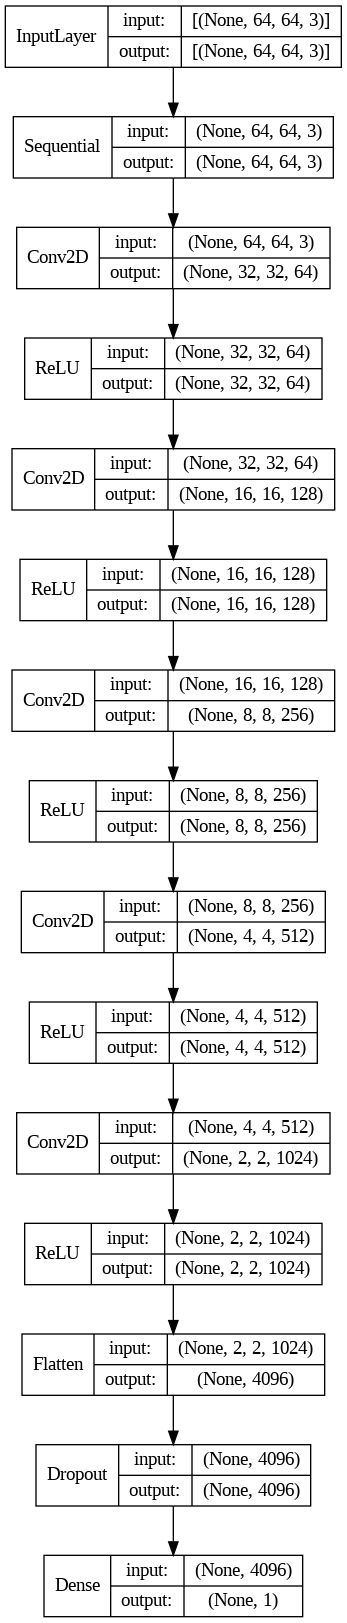

In [ ]:
plot_model(model, to_file="cnn_64.png", show_shapes=True, show_layer_names = False)

## Model Training

In [ ]:
# Clear out any prior log data.
!rm -rf logs

# Sets up a log directory.
log_dir = "/path/models/64/BMI/evaluation/"
tensorboard_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# Train the model
history = model.fit(images_train, bmi_train, epochs=50, batch_size=128, 
                    validation_data=(images_test, bmi_test),
                    callbacks=[tensorboard_callback])

Epoch 1/50
375/375 [==============================] - 17s 11ms/step - loss: 5.4578 - mae: 5.4578 - val_loss: 4.7842 - val_mae: 4.7842
Epoch 2/50
375/375 [==============================] - 3s 9ms/step - loss: 4.4464 - mae: 4.4464 - val_loss: 4.0718 - val_mae: 4.0718
Epoch 3/50
375/375 [==============================] - 3s 9ms/step - loss: 4.2641 - mae: 4.2641 - val_loss: 3.9421 - val_mae: 3.9421
Epoch 4/50
375/375 [==============================] - 3s 8ms/step - loss: 4.1569 - mae: 4.1569 - val_loss: 3.9624 - val_mae: 3.9624
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 4.0347 - mae: 4.0347 - val_loss: 3.8914 - val_mae: 3.8914
Epoch 6/50
375/375 [==============================] - 3s 8ms/step - loss: 3.9811 - mae: 3.9811 - val_loss: 3.8333 - val_mae: 3.8333
Epoch 7/50
375/375 [==============================] - 3s 8ms/step - loss: 3.9069 - mae: 3.9069 - val_loss: 3.6993 - val_mae: 3.6993
Epoch 8/50
375/375 [==============================] - 3s 8ms/step - loss: 

In [ ]:
model.save("path/evaluation_64_cnn_BMI.h5")

## Evaluation

In [ ]:
# Evaluate the model on test data
loss, mae = model.evaluate(images_test, bmi_test, verbose=0)
print("Test MAE:", mae)

Test MAE: 3.4619274139404297


In [ ]:
# crate new variables to plot and use the CNN to predict BMI from images

true_values = bmi_test
predicted_values = model.predict(images_test, verbose = 0)
print(true_values.shape)
print(predicted_values.shape)

(12000,)
(12000, 1)


In [ ]:
def create_scatter_plot(true_values, predicted_values, title = ""):
    # reshape predicted values
    predicted_values = np.squeeze(predicted_values)

    # Plot the scatter plot with separate alpha values for each gender
    ax = sns.scatterplot(x=predicted_values, y=true_values)
    sns.set(style="darkgrid")
    
    # Add a trendline and correlation value to the plot
    slope, intercept, r_value, p_value, std_err = linregress(predicted_values,true_values)
    sns.regplot(x=predicted_values, y=true_values, ax=ax, scatter=False, color='black', label=f'Trendline: {slope:.2f}x + {intercept:.2f}\nCorrelation: {r_value:.2f}')
    
    # Add labels, title, and legend
    ax.set_xlabel("Predicted BMI")
    ax.set_ylabel("True BMI")
    ax.set_title(title)
    ax.legend(loc='upper left', labels=["BMI", f'Trendline: {slope:.2f}x + {intercept:.2f}\nCorrelation: {r_value:.2f}'], markerscale=2, facecolor='white')

    plt.show()

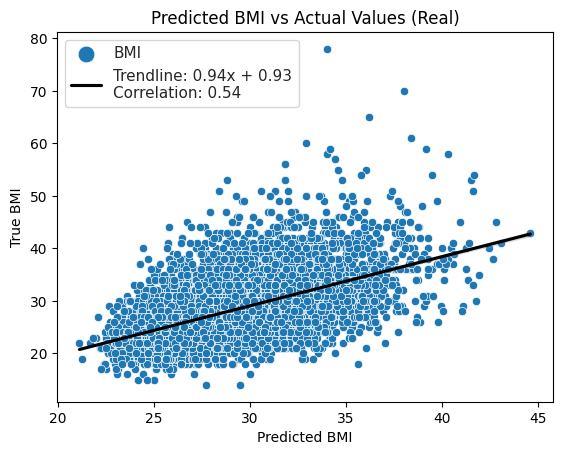

In [ ]:
# plot predicted BMI values vs actual values
create_scatter_plot(true_values, predicted_values, title = "Predicted BMI vs Actual Values (Real)")

## Test CNN with Generated Images

In [ ]:
generator = load_model("/content/drive/MyDrive/inmates/models/64/BMI/cGan/models/inmates_conditional_generator_V2_continous_epoch_final.h5")

In [ ]:
model = load_model("/content/drive/MyDrive/inmates/models/64/BMI/evaluation/evaluation_64_cnn_BMI.h5")

In [ ]:
# Define helper functions for the Generator

def create_distribution_and_sample(array, n_samples):
    # Create a probability distribution from the array
    dist = np.array(array) / sum(array)
    # Draw n samples from the distribution
    sample_indices = np.random.choice(len(array), size=n_samples, p=dist)
    # Get the actual values corresponding to the sampled indices
    samples = [array[i] for i in sample_indices]
    return asarray(samples)

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = create_distribution_and_sample(bmi_train, n_samples )
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input], verbose = 0)

    return images, labels_input

In [ ]:
# Generate 10000 random samples via generator
fake_images, fake_labels = generate_fake_samples(generator, 100, 10000)

In [ ]:
# scale the pixel values from [-1,1] to [0,255]
fake_images = (fake_images + 1) / 2.0 * 255
fake_images = fake_images.astype(np.uint8)

(10000, 64, 64, 3)
(10000,)


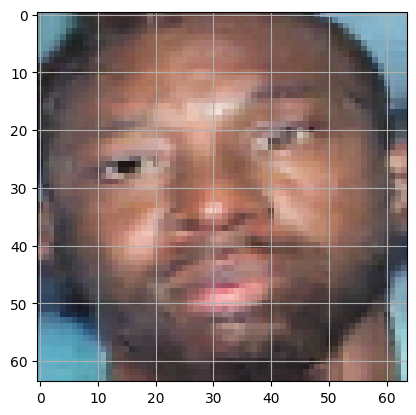

In [ ]:
# Verify prediction

print(fake_images.shape)
print(fake_labels.shape)
plt.imshow(fake_images[:1][0])
plt.grid(None)

In [ ]:
# Use CNN to predict BMI on generated images

predicted_fake_labels = model.predict(fake_images)

313/313 [==============================] - 1s 4ms/step


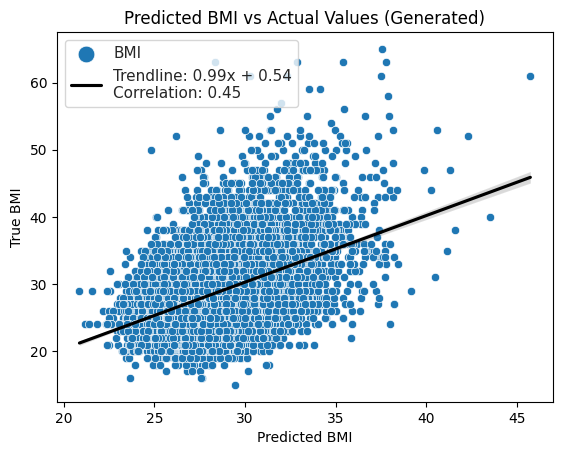

In [ ]:
# Plot predicted BMI values vs actual values

create_scatter_plot(fake_labels, predicted_fake_labels, title = "Predicted BMI vs Actual Values (Generated)")

In [ ]:
def create_combined_scatter_plot(true_values, predicted_values, fake_labels, predicted_fake_labels):
    plt.figure(figsize=(8, 6))
    # reshape predicted values
    predicted_values = np.squeeze(predicted_values)
    predicted_fake_labels = np.squeeze(predicted_fake_labels)

    # Calculate the Mean Absolute Error (MAE) for both datasets
    mae_r = np.mean(np.abs(true_values - predicted_values))
    mae_f = np.mean(np.abs(fake_labels - predicted_fake_labels))

    # Plot the scatter plot with separate alpha values for each gender
    ax = sns.scatterplot(x=predicted_values, y=true_values, label=f"Real BMI")
    sns.scatterplot(x=predicted_fake_labels, y=fake_labels, color='pink', ax=ax, label="Generated BMI")
    sns.set(style="darkgrid")
    
    # Add a trendline and correlation value to the plot
    slope_r, intercept_r, r_value_r, p_value_r, std_err_r = linregress(predicted_values,true_values)
    sns.regplot(x=predicted_values, y=true_values, ax=ax, scatter=False, color='darkblue', label=f'Real Trendline: {slope_r:.2f}x + {intercept_r:.2f}\nCorrelation: {r_value_r:.2f}\nMAE: {mae_r:.2f}')

    slope_f, intercept_f, r_value_f, p_value_f, std_err_f = linregress(predicted_fake_labels, fake_labels)
    sns.regplot(x=predicted_fake_labels, y=fake_labels, ax=ax, scatter=False, color='coral', label=f'Generated Trendline: {slope_f:.2f}x + {intercept_f:.2f}\nCorrelation: {r_value_f:.2f}\nMAE: {mae_f:.2f}')
    
    # Add labels, title, and legend
    ax.set_xlabel("Predicted BMI")
    ax.set_ylabel("True / Generated BMI")
    ax.set_title("Predicted vs Actual BMI (Real & Generated)")
    ax.legend(loc='upper left', markerscale=2, facecolor='white')

    plt.savefig('true_predicted_bmi.png', bbox_inches='tight')
    plt.show()


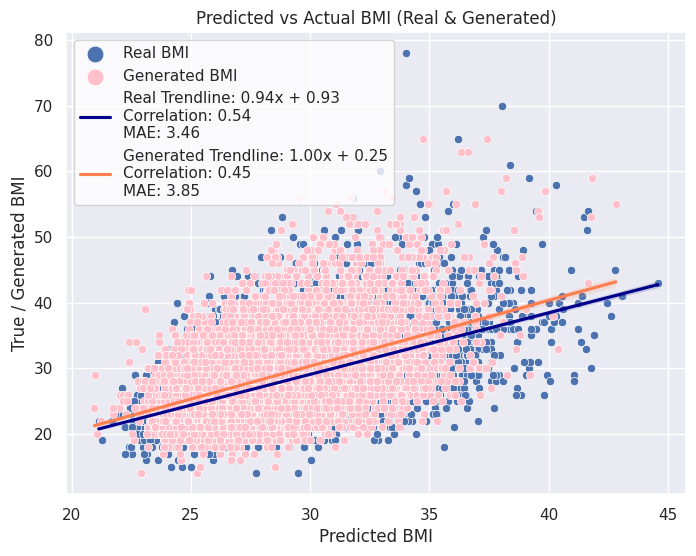

In [ ]:
# Comboine the two scatter plots from before -> compare generator vs real dataset

create_combined_scatter_plot(true_values, predicted_values, fake_labels, predicted_fake_labels)

# SSIM cGAN (Mode Collapse)

In [ ]:
# generate random samples to calculate SSIM
fake_images, fake_labels = generate_fake_samples(generator, 100, 100)

# scale the pixel values from [-1,1] to [0,255]
fake_images = (fake_images + 1) / 2.0 * 255
fake_images = fake_images.astype(np.uint8)

In [ ]:
# Define function to calculate the Structural Similarity Index
def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255.00))


# Define functin to calculate the pair-wise SSIM -> Number of pairs = n(n-1)/2
def calculate_ssim(dataset):
    ssim_values = []
    for i, image1 in enumerate(dataset):
        for j, image2 in enumerate(dataset):
            if i < j:
                ssim = SSIM(image1, image2)
                ssim_values.append(ssim)
    return ssim_values

In [ ]:
def create_density_plot_ssim(ssim_real, ssim_fake):
    plt.figure(figsize=(9, 6))
    
    # Create the plot using seaborn
    sns.kdeplot(ssim_real, label='SSIM Real Images', fill=True, alpha=0.3)
    sns.kdeplot(ssim_fake, color='pink', label='SSIM Fake Images', fill=True)
    sns.set(style="darkgrid")
    
    # calculate and display mean, median, and std values
    real_mean = ssim_real.mean()
    real_median = np.median(ssim_real)
    real_std = ssim_real.std()
    fake_mean = ssim_fake.mean()
    fake_median = np.median(ssim_fake)
    fake_std = ssim_fake.std()
    
    # add a vertical line at the mean and display mean, median, and std values in the legend
    plt.axvline(real_mean, color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(fake_mean, color='pink', linestyle='dashed', linewidth=1)
  
    # create the legend with mean, median, and std values and the mean line
    real_legend = f"Real Images - Mean: {real_mean:.2f}, Median: {real_median:.2f}, Std: {real_std:.2f}"
    fake_legend = f"Fake Images - Mean: {fake_mean:.2f}, Median: {fake_median:.2f}, Std: {fake_std:.2f}"
    plt.legend([real_legend, fake_legend], fontsize=10, facecolor='white')

    plt.xlabel('SSIM Values')
    plt.ylabel('Density')
    plt.title('SSIM Values Real and Fake Images')


    plt.savefig('ssim_density.png', bbox_inches='tight')
    plt.show()


In [ ]:
# get a random sample from the test set to calculate the SSIM
random_indices = random.sample(range(len(images_test)), k=100)
random_test_images = images_test[random_indices]

In [ ]:
# calculate pair-wise SSIM values
ssim_fake = np.array(calculate_ssim(fake_images))
ssim_real = np.array(calculate_ssim(random_test_images))

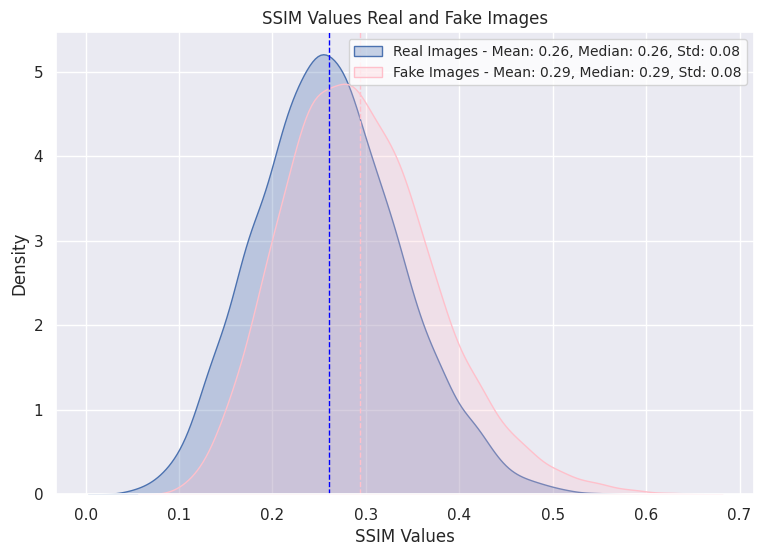

In [ ]:
# create density plot to compare the different distributions
create_density_plot_ssim(ssim_real, ssim_fake)

# FID


In [ ]:
# specify the path of the folder containing the models
model_path = "/path/models/"

# create an empty list to store the filenames
model_list = []

# use a for loop to iterate through all files in the folder
for filename in os.listdir(model_path):
    # check if the filename is a file (not a directory)
    if os.path.isfile(os.path.join(model_path, filename)):
        # append the filename to the list
        model_list.append(filename)

# print the list of filenames
print(model_list)
print(len(model_list))

['inmates_conditional_generator_V2_continous_epoch_0_20230307-155620.h5', 'inmates_conditional_generator_V2_continous_epoch_10_20230307-160944.h5', 'inmates_conditional_generator_V2_continous_epoch_20_20230307-162323.h5', 'inmates_conditional_generator_V2_continous_epoch_30_20230307-163656.h5', 'inmates_conditional_generator_V2_continous_epoch_40_20230307-165021.h5', 'inmates_conditional_generator_V2_continous_epoch_50_20230307-170352.h5', 'inmates_conditional_generator_V2_continous_epoch_60_20230307-171716.h5', 'inmates_conditional_generator_V2_continous_epoch_70_20230307-173048.h5', 'inmates_conditional_generator_V2_continous_epoch_80_20230307-174411.h5', 'inmates_conditional_generator_V2_continous_epoch_90_20230307-175740.h5', 'inmates_conditional_generator_V2_continous_epoch_100_20230307-181117.h5', 'inmates_conditional_generator_V2_continous_epoch_110_20230307-182445.h5', 'inmates_conditional_generator_V2_continous_epoch_120_20230307-183840.h5', 'inmates_conditional_generator_V2_c

In [ ]:
# define all helper functions

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input], verbose = 0)
    # scale the pixel values from [-1,1] to [0,255]
    images = (images + 1) / 2.0 * 255
    images = images.astype(np.uint8)
    return images

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1, verbose = 0)
    act2 = model.predict(images2, verbose = 0)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
# define a function to go through all saved models and calculate the FID

def histortical_fid(model_list, samples):

    # remove warning when loading a model
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # create list
    fid_scores = []

    random_indices = random.sample(range(len(images_test)), k=samples)
    real_images = images_test[random_indices]
    real_images = real_images.astype('float32')
    real_images = scale_images(real_images, (75,75,3))
    real_images = preprocess_input(real_images)
    
    # loop through all models
    for gen in model_list:
        generator = load_model(model_path + gen)
 
        # prepare the inception v3 model
        model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3)) # minimum dimensions required
        # define two fake collections of images
        fake_images = generate_fake_samples(generator = generator, latent_dim = 100, n_samples = samples)
        # convert integer to floating point values
        fake_images = fake_images.astype('float32')
        # resize images
        fake_images = scale_images(fake_images, (75,75,3))
        # pre-process images
        fake_images = preprocess_input(fake_images)
        # fid between fake_images and real_images
        fid = calculate_fid(model, fake_images, real_images)
        fid_scores.append(fid)
        print('FID: %.3f' % fid)

    # display the warning again when loading a model
    logging.getLogger('tensorflow').setLevel(logging.WARNING)

    return fid_scores

In [ ]:
scores = histortical_fid(model_list, 5000)

87910968/87910968 [==============================] - 5s 0us/step
FID: 587.158
FID: 122.659
FID: 75.961
FID: 63.160
FID: 76.644
FID: 57.074
FID: 59.750
FID: 62.575
FID: 53.933
FID: 51.116
FID: 51.777
FID: 52.204
FID: 44.683
FID: 44.700
FID: 56.342
FID: 72.460
FID: 56.452
FID: 66.673
FID: 101.646
FID: 65.658
FID: 74.673
FID: 71.967
FID: 65.659
FID: 69.189
FID: 62.146
FID: 81.930
FID: 57.812
FID: 51.038
FID: 59.030
FID: 66.928
FID: 77.064


In [ ]:
# define function to plot the historical FID values

def create_fid_chart(fid_scores, title = ""):
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=(range(0, 10*len(model_list), 10)), y=fid_scores)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('FID Scores')
    plt.savefig('fid_scores.png', bbox_inches='tight')
    plt.show()

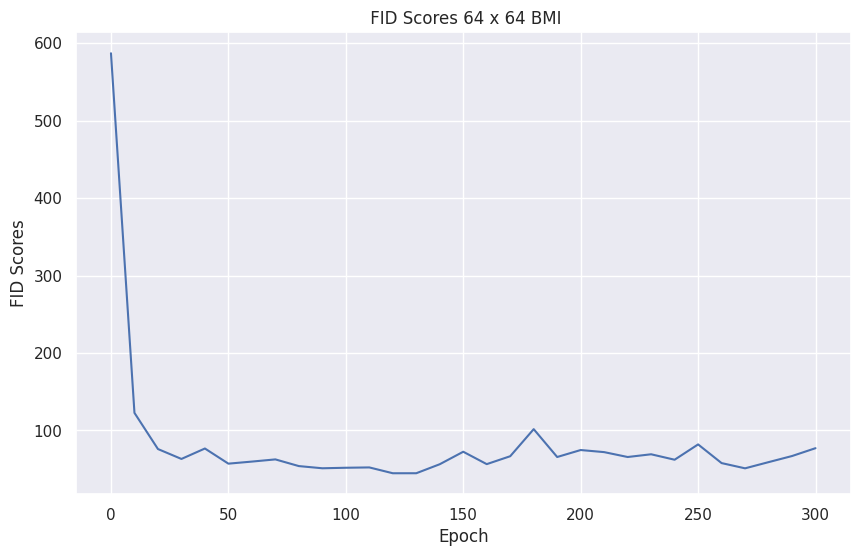

In [ ]:
# plot historical FID values
create_fid_chart(scores, " FID Scores 64 x 64 BMI")

In [ ]:
from google.colab import runtime
runtime.unassign()